<a href="https://colab.research.google.com/github/fajarwr/CNN_3D_Permaebility/blob/master/CNN_3D_Permeability_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing the libraries
import numpy as np
import tensorflow as tf
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

In [2]:
# Running the below code every time
import keras as K
np.random.seed(0)
rn.seed(0)
tf.set_random_seed(0)

sess = tf.Session(graph=tf.get_default_graph())
K.backend.set_session(sess)

Using TensorFlow backend.


In [3]:
#Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd

/root


In [5]:
cd /content

/content


In [0]:
#Make dir 001 and 002 in colab
#import os
dir001, dir002, dir005 = 'CNN_Permeability/001_PythonCodes/CNN_3D_Permaebility', 'CNN_Permeability/002_Data/Berea_Sandstone_npy', 'CNN_Permeability/005_Result/CNN_3D'
if not os.path.exists(dir001):
    os.makedirs(dir001)
if not os.path.exists(dir002):
    os.makedirs(dir002)
if not os.path.exists(dir005):
    os.makedirs(dir005)

In [7]:
os.listdir()

['.config', 'CNN_Permeability', 'gdrive', 'sample_data']

In [0]:
#Extract zip file to colab
import zipfile
with zipfile.ZipFile('gdrive/My Drive/CNN_Permeability/002_Data/Berea_Sandstone_npy.zip','r') as zip_ref:
    zip_ref.extractall('CNN_Permeability/002_Data/Berea_Sandstone_npy')

In [9]:
#Copy datagen from gdrive to colab
from shutil import copyfile

copyfile('gdrive/My Drive/CNN_Permeability/001_PythonCodes/CNN_3D_Permaebility/DataGenerator_3D_Classes.py',
         'CNN_Permeability/001_PythonCodes/CNN_3D_Permaebility/DataGenerator_3D_Classes.py')

'CNN_Permeability/001_PythonCodes/CNN_3D_Permaebility/DataGenerator_3D_Classes.py'

In [0]:
from __future__ import division, print_function, absolute_import
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D, BatchNormalization, Input
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, TensorBoard
import h5py
import pandas as pd
#import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
#import os
import sys
import matplotlib.pyplot as plt
import re
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.model_selection import train_test_split
#from keras import backend as K
#from keras.callbacks import ModelCheckpoint
import keras

In [0]:
#Define r square matric
def r2_keras(y_true, y_pred):
    SS_res =  K.backend.sum(K.backend.square(y_true - y_pred)) 
    SS_tot = K.backend.sum(K.backend.square(y_true - K.backend.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.backend.epsilon()) )

In [12]:
cd

/root


In [13]:
cd /content

/content


In [0]:
os.chdir('CNN_Permeability/001_PythonCodes/CNN_3D_Permaebility')

In [0]:
#Import datagenerator taken from 
#https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from DataGenerator_3D_Classes import DataGenerator

In [0]:
#Experiment number
exp_num = 9
os.chdir('../../005_Result/CNN_3D')
#if any('00'+str(exp_num) in s for s in os.listdir(os.getcwd())):
#    sys.exit('Alert : There is already 00'+str(exp_num)+' experiment result!!')

In [0]:
#Load the data
dim1,dim2,dim3,chn = 100,100,100,1
training_len = 8000
testing_len = 1260
total_len = training_len + testing_len
phi = []
ssa = []
os.chdir('../../002_Data/Berea_Sandstone_npy')
for image3D_npy in os.listdir(os.getcwd())[:total_len]:
    phi.append([float(s) for s in re.findall('[-+]?\d*\.\d+|\d+',
                image3D_npy)][1])
    ssa.append([float(s) for s in re.findall('[-+]?\d*\.\d+|\d+',
                image3D_npy)][2])
k = np.power(1-np.array(phi), 3)/np.power(ssa, 2)
k_norm = k/np.max(k)

In [0]:
# Parameters
params = {'dim': (dim1,dim2,dim3),
          'batch_size': 20,
          'n_classes': 1,
          'n_channels': chn,
          'shuffle': False}

In [0]:
#Datasets
partition = {
		'train': os.listdir(os.getcwd())[:training_len],
		'validation': os.listdir(os.getcwd())[training_len:total_len],
        'total' : os.listdir(os.getcwd())[:total_len]
		}
labels = dict(zip(os.listdir(os.getcwd())[:total_len], k_norm))

In [20]:
len(labels)

9260

In [0]:
# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
total_generator = DataGenerator(partition['total'], labels, **params)

In [22]:
#Define a model 9
model = Sequential()
model.add(Conv3D(32, kernel_size=5, strides=(2, 2, 2), padding='valid',
                 data_format='channels_last', dilation_rate=(1, 1, 1),
                 activation='relu', use_bias=True,
                 kernel_initializer=keras.initializers.glorot_uniform(seed=0), bias_initializer='zeros',
                 kernel_regularizer=None, bias_regularizer=None, 
                 activity_regularizer=None, kernel_constraint=None,
                 bias_constraint=None, input_shape=(dim1, dim2, dim3, chn)))
model.add(Conv3D(32, kernel_size=5, strides=(2, 2, 2), padding='valid',
                 data_format='channels_last', dilation_rate=(1, 1, 1),
                 activation='relu', use_bias=True,
                 kernel_initializer=keras.initializers.glorot_uniform(seed=0), bias_initializer='zeros',
                 kernel_regularizer=None, bias_regularizer=None, 
                 activity_regularizer=None, kernel_constraint=None,
                 bias_constraint=None))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='valid',
                       data_format='channels_last'))
model.add(Conv3D(32, kernel_size=3, strides=(1, 1, 1), padding='valid',
                 data_format='channels_last', dilation_rate=(1, 1, 1),
                 activation='relu', use_bias=True,
                 kernel_initializer=keras.initializers.glorot_uniform(seed=0), bias_initializer='zeros',
                 kernel_regularizer=None, bias_regularizer=None, 
                 activity_regularizer=None, kernel_constraint=None,
                 bias_constraint=None, input_shape=(dim1, dim2, dim3, chn)))
model.add(Conv3D(32, kernel_size=3, strides=(1, 1, 1), padding='valid',
                 data_format='channels_last', dilation_rate=(1, 1, 1),
                 activation='relu', use_bias=True,
                 kernel_initializer=keras.initializers.glorot_uniform(seed=0), bias_initializer='zeros',
                 kernel_regularizer=None, bias_regularizer=None, 
                 activity_regularizer=None, kernel_constraint=None,
                 bias_constraint=None))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1), padding='valid',
                       data_format='channels_last'))
model.add(Flatten(data_format='channels_last'))
model.add(Dense(64, activation='relu', use_bias=True,
                kernel_initializer=keras.initializers.glorot_uniform(seed=0), bias_initializer='zeros',
                kernel_regularizer=None, bias_regularizer=None,
                activity_regularizer=None, kernel_constraint=None,
                bias_constraint=None))
model.add(Dense(1, activation=None, use_bias=True,
                kernel_initializer=keras.initializers.glorot_uniform(seed=0), bias_initializer='zeros',
                kernel_regularizer=None, bias_regularizer=None,
                activity_regularizer=None, kernel_constraint=None,
                bias_constraint=None))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#Compile the model
model.compile(optimizer='Adam', loss='mean_squared_error', metrics=[r2_keras],
              loss_weights=None, sample_weight_mode=None,weighted_metrics=None,
              target_tensors=None)

In [0]:
#Change to data directory
os.chdir('../../002_Data/Berea_Sandstone_npy')

In [0]:
#This checkpoint object will store the model parameters in the file "weights.hdf5"
checkpoint = K.callbacks.ModelCheckpoint(filepath='../../005_Result/CNN_3D/Weights_CNN3D_00'+str(exp_num)+'.hdf5', monitor='val_loss')

In [26]:
# Train model on dataset
history = model.fit_generator(generator=training_generator, validation_data = validation_generator, epochs=20,
                    callbacks=[checkpoint], workers=1, use_multiprocessing=False)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
400/400 [==============================] - 450s 1s/step - loss: 1.1126 - r2_keras: -76.8918 - val_loss: 0.0079 - val_r2_keras: 0.4298
Epoch 2/20
400/400 [==============================] - 436s 1s/step - loss: 0.0055 - r2_keras: 0.5863 - val_loss: 0.0043 - val_r2_keras: 0.6856
Epoch 3/20
400/400 [==============================] - 437s 1s/step - loss: 0.0032 - r2_keras: 0.7500 - val_loss: 0.0020 - val_r2_keras: 0.8486
Epoch 4/20
400/400 [==============================] - 437s 1s/step - loss: 0.0023 - r2_keras: 0.8241 - val_loss: 0.0028 - val_r2_keras: 0.7730
Epoch 5/20
400/400 [==============================] - 437s 1s/step - loss: 0.0017 - r2_keras: 0.8654 - val_loss: 0.0017 - val_r2_keras: 0.8681
Epoch 6/20
400/400 [==============================] - 437s 1s/step - loss: 0.0017 - r2_keras: 0.8688 - val_loss: 0.0013 - val_r2_keras: 0.9017
Epoch 7/20
400/400 [==============================] - 437s 1s/step - loss: 0.0012 - r2_keras

In [0]:
#Save history
history_df = pd.DataFrame.from_dict(history.history)
history_df.to_excel('../../005_Result/CNN_3D/History_CNN3D_00'+str(exp_num)+'.xlsx')

In [28]:
#Store the training & testing result
total_result = model.predict_generator(generator=total_generator, steps=None,
                                  max_queue_size=10, workers=1,
                                  use_multiprocessing=False, verbose=1)

463/463 [==============================] - 436s 943ms/step


In [0]:
#testing_len = 1260
#Save result
training_result = {
		'true_training': np.reshape(k_norm[:training_len]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(training_len,)),
		'pred_training': np.reshape(total_result[:training_len]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(training_len,)), 
    'phi': 1-np.array(phi[:training_len])
		}
testing_result = {
    'true_testing': np.reshape(k_norm[training_len:total_len]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(testing_len,)),
		'pred_testing': np.reshape(total_result[training_len:total_len]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(testing_len,)),
    'phi': 1-np.array(phi[training_len:total_len])
        }
training_result_df = pd.DataFrame.from_dict(training_result)
testing_result_df = pd.DataFrame.from_dict(testing_result)
training_result_df.to_excel('../../005_Result/CNN_3D/Training_CNN3D_00'+
                            str(exp_num)+'_'+str(r2_score (k_norm[:training_len]*np.max(k), total_result[:training_len]*np.max(k))*100)+'.xlsx')
testing_result_df.to_excel('../../005_Result/CNN_3D/Testing_CNN3D_00'+
                            str(exp_num)+'_'+str(r2_score(k_norm[training_len:total_len]*np.max(k), total_result[training_len:total_len]*np.max(k))*100)+'.xlsx')


0.9433199724320637
0.9150049268418401


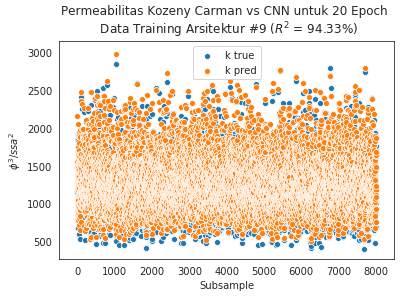

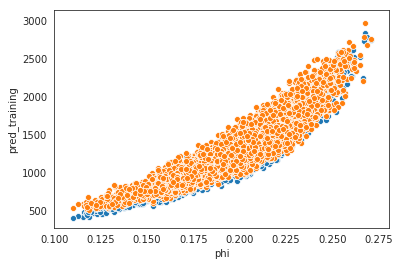

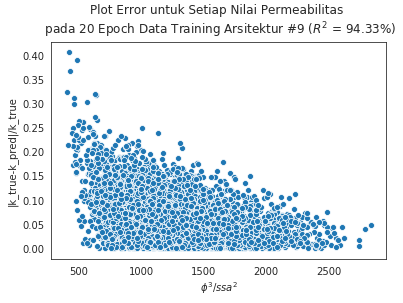

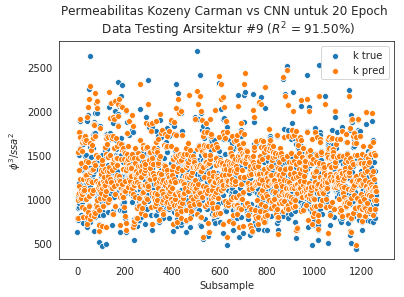

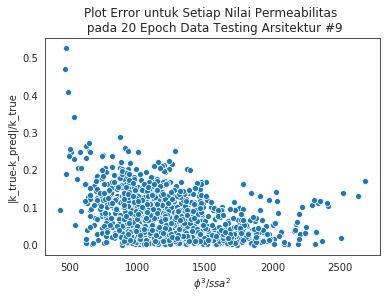

In [30]:
#Impport data
i = exp_num
Training = training_result_df
Error_training =np.abs(Training['true_training'].values-Training['pred_training'].values)/Training['true_training'].values
Training['Error'] = Error_training
Training.index.names = ['Subsample']
Testing = testing_result_df
Error_testing =np.abs(Testing['true_testing'].values-Testing['pred_testing'].values)/Testing['true_testing'].values
Testing['Error'] = Error_testing
Testing.index.names = ['Subsample']
    
#Plot training data
plt.figure()
sns.scatterplot(x=range(1,training_len+1), y='true_training', data = Training)
sns.scatterplot(x=range(1,training_len+1), y='pred_training', data = Training)
plt.ylabel('$\phi^3/ssa^2$')
plt.xlabel('Subsample')
plt.title('Permeabilitas Kozeny Carman vs CNN untuk 20 Epoch \n Data Training Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Training['true_training'], Training['pred_training'])*100))
plt.legend(['k true', 'k pred'])
#plt.xticks(np.arange(1,training_len+1,testing_len))

#Plot training data
plt.figure()
#sns.scatterplot(x=phi[:training_len], y=Training.loc[:training_len, 'true_training'], size = 1)
#sns.scatterplot(x=phi[:training_len], y=Training.loc[:training_len, 'pred_training'], size = 1)
sns.scatterplot(x='phi', y='true_training', data = Training)
sns.scatterplot(x='phi', y='pred_training', data = Training)
#plt.ylabel('$\phi^3/ssa^2$')
#plt.xlabel('Subsample')
#plt.title('Permeabilitas Kozeny Carman vs CNN untuk 20 Epoch \n Data Training Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Training['true_training'], Training['pred_training'])*100))
#plt.legend(['k true', 'k pred'])
#plt.xticks(np.arange(1,training_len+1,1000))
    
#Plot error training data
plt.figure()
sns.scatterplot(x='true_training', y='Error', data = Training)
plt.ylabel('|k_true-k_pred|/k_true')
plt.xlabel('$\phi^3/ssa^2$')
plt.title('Plot Error untuk Setiap Nilai Permeabilitas \n pada 20 Epoch Data Training Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Training['true_training'], Training['pred_training'])*100))

              
#Plot testing data
plt.figure()
sns.scatterplot(x=range(1,testing_len+1), y='true_testing', data = Testing)
sns.scatterplot(x=range(1,testing_len+1), y='pred_testing', data = Testing)
plt.ylabel('$\phi^3/ssa^2$')
plt.xlabel('Subsample')
plt.title('Permeabilitas Kozeny Carman vs CNN untuk 20 Epoch \n Data Testing Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Testing['true_testing'], Testing['pred_testing'])*100))
plt.legend(['k true', 'k pred'])
#plt.xticks(np.arange(1,testing_len+1,1))
    
#Plot error testing data
plt.figure()
sns.scatterplot(x='true_testing', y='Error', data = Testing)
plt.ylabel('|k_true-k_pred|/k_true')
plt.xlabel('$\phi^3/ssa^2$')
plt.title('Plot Error untuk Setiap Nilai Permeabilitas \n pada 20 Epoch Data Testing Arsitektur #{}' .format(i))

print(r2_score(Training['true_training'], Training['pred_training']))
print(r2_score(Testing['true_testing'], Testing['pred_testing']))

In [0]:
#Copy result from colab to gdrive
from shutil import copyfile
#History
copyfile('../../005_Result/CNN_3D/History_CNN3D_00'+str(exp_num)+'.xlsx',
         '../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/History_CNN3D_00'+str(exp_num)+'.xlsx')
#Training
copyfile('../../005_Result/CNN_3D/Training_CNN3D_00'+
         str(exp_num)+'_'+str(r2_score (k_norm[:training_len]*np.max(k), total_result[:training_len]*np.max(k))*100)+'.xlsx',
         '../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Training_CNN3D_00'+str(exp_num)+'.xlsx')
         
#Testing
copyfile('../../005_Result/CNN_3D/Testing_CNN3D_00'+
         str(exp_num)+'_'+str(r2_score(k_norm[training_len:total_len]*np.max(k), total_result[training_len:total_len]*np.max(k))*100)+'.xlsx',
         '../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Testing_CNN3D_00'+str(exp_num)+'.xlsx')

'../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Testing_CNN3D_001000.xlsx'

In [31]:
print(history.history.keys())

dict_keys(['val_loss', 'val_r2_keras', 'loss', 'r2_keras'])


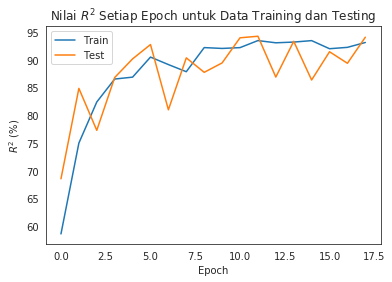

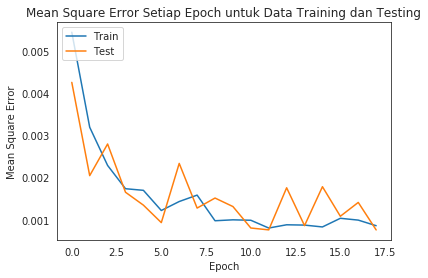

In [32]:
# summarize history for accuracy
plt.plot(np.array(history.history['r2_keras'][1:-1])*100)
plt.plot(np.array(history.history['val_r2_keras'][1:-1])*100)
plt.title('Nilai $R^2$ Setiap Epoch untuk Data Training dan Testing')
plt.ylabel('$R^2$ (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'][1:-1])
plt.plot(history.history['val_loss'][1:-1])
plt.title('Mean Square Error Setiap Epoch untuk Data Training dan Testing')
plt.ylabel('Mean Square Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
###Visualize convolution###

In [34]:
from keras.models import load_model
#model = load_model(filepath='../../../Weights_CNN3D_00991.hdf5', custom_objects={'r2_keras': r2_keras})
model = load_model(filepath='../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Weights_CNN3D_00991.hdf5', custom_objects={'r2_keras': r2_keras})
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 48, 48, 48, 32)    4032      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 22, 22, 22, 32)    128032    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 21, 21, 21, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 19, 32)    27680     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 17, 17, 17, 32)    27680     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 16, 32)    0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
__________

In [0]:

print('kernel')
for layer in model.layers:
  if 'conv' in layer.name or 'dense' in layer.name:
    print(layer.name, layer.get_weights()[0].shape)
print('bias')
for layer in model.layers:
  if 'conv' in layer.name or 'dense' in layer.name:
    print(layer.name, layer.get_weights()[1].shape)

kernel
conv3d_1 (5, 5, 5, 1, 32)
conv3d_2 (5, 5, 5, 32, 32)
conv3d_3 (3, 3, 3, 32, 32)
conv3d_4 (3, 3, 3, 32, 32)
dense_1 (131072, 128)
dense_2 (128, 128)
dense_3 (128, 128)
dense_4 (128, 64)
dense_5 (64, 1)
bias
conv3d_1 (32,)
conv3d_2 (32,)
conv3d_3 (32,)
conv3d_4 (32,)
dense_1 (128,)
dense_2 (128,)
dense_3 (128,)
dense_4 (64,)
dense_5 (1,)


In [0]:
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax
def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(values):
    n, bins, patches = plt.hist(values.reshape(-1), 50, normed=1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    for c, p in zip(normalize(bin_centers), patches):
        plt.setp(p, 'facecolor', cm.gray(c))

    plt.show()
def explode(data):
    shape_arr = np.array(data.shape)
    size = shape_arr[:3]*2 - 1
    exploded = np.zeros(np.concatenate([size, shape_arr[3:]]), dtype=data.dtype)
    exploded[::2, ::2, ::2] = data
    return exploded

def expand_coordinates(indices):
    x, y, z = indices
    x[1::2, :, :] += 1
    y[:, 1::2, :] += 1
    z[:, :, 1::2] += 1
    return x, y, z

def plot_cube(cube, row, col, idx,angle=320):
    cube = normalize(cube)

    facecolors = cm.gray(cube)
    facecolors[:,:,:,-1] = cube
    facecolors = explode(facecolors)

    filled = facecolors[:,:,:,-1] != 0
    x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

    #fig = plt.figure(figsize=(30/2.54, 30/2.54))
    ax = fig.add_subplot(row, col, idx, projection='3d')
    #ax = fig.gca(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_zticklabels([])


    ax.voxels(x, y, z, filled, facecolors=facecolors, edgecolor=None)
    #plt.show()

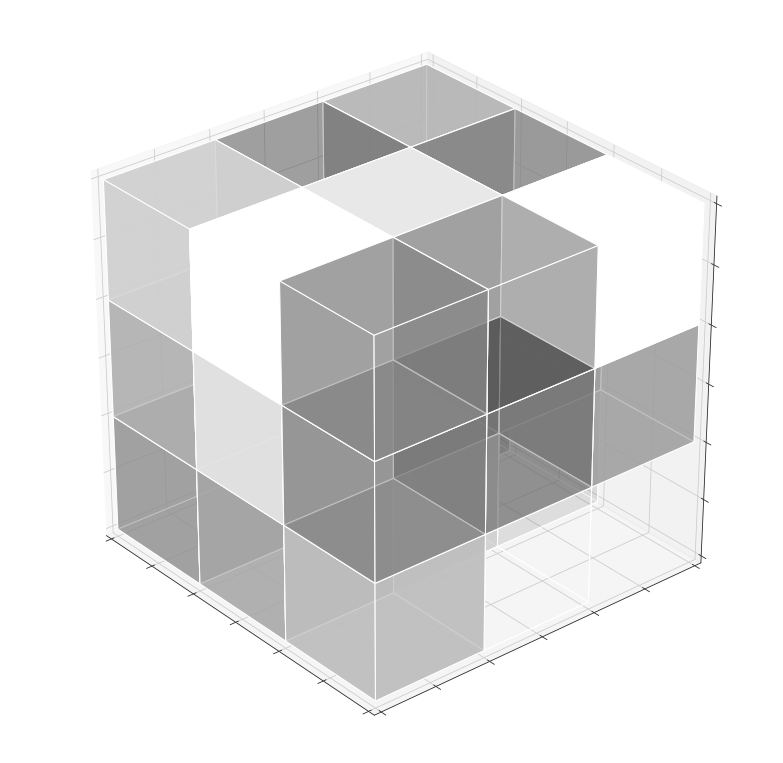

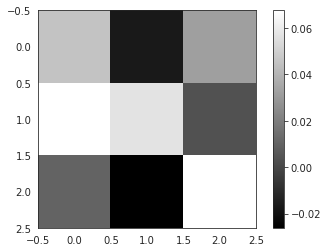

In [0]:
IMG_DIM = 3
# retrieve weights from the second hidden layer
filters, biases = model.layers[3].get_weights()
# normalize filter values to 0-1 so we can visualize them
#f_min, f_max = filters.min(), filters.max()
#filters = (filters - f_min) / (f_max - f_min)
n_filters= 1
fig = plt.figure(figsize=(35/2.54, 35/2.54))
for fil_idx in range(n_filters):
  plot_cube(filters[:,:,:,0,12], row=1, col=1, idx=fil_idx+1)
plt.show()

plt.figure()
plt.imshow(filters[:,:,-1,0,12],cmap='gray')
plt.colorbar()
plt.show()

In [0]:
#Load the data
dim1,dim2,dim3,chn = 100,100,100,1
training_len = 1
testing_len = 1
total_len = training_len + testing_len
phi = []
ssa = []
os.chdir('../../002_Data/Berea_Sandstone_npy')
for image3D_npy in os.listdir(os.getcwd())[:total_len]:
    phi.append([float(s) for s in re.findall('[-+]?\d*\.\d+|\d+',
                image3D_npy)][1])
    ssa.append([float(s) for s in re.findall('[-+]?\d*\.\d+|\d+',
                image3D_npy)][2])
k = np.power(1-np.array(phi), 3)/np.power(ssa, 2)
k_norm = k/np.max(k)


# Parameters
params = {'dim': (dim1,dim2,dim3),
          'batch_size': 1,
          'n_classes': 1,
          'n_channels': chn,
          'shuffle': False}

#Datasets
partition = {
		'train': os.listdir(os.getcwd())[:training_len],
		'validation': os.listdir(os.getcwd())[training_len:total_len],
        'total' : os.listdir(os.getcwd())[:total_len]
		}
labels = dict(zip(os.listdir(os.getcwd())[:total_len], k_norm))

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)
total_generator = DataGenerator(partition['total'], labels, **params)

In [0]:
os.listdir(os.getcwd())[0]

'berea_01019_0.7928930_0.0873476.npy'

In [0]:
# plot feature map of first conv layer for given image
#from keras.applications.vgg16 import VGG16
from keras.models import load_model
model = load_model(filepath='../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Weights_CNN3D_00991.hdf5', custom_objects={'r2_keras': r2_keras})
#from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
#from matplotlib import pyplot
from numpy import expand_dims
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
#model = Model(inputs=model.inputs, outputs=model.inputs)
model.summary()

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f05e489eef0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 880564064


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1_input (InputLayer)  (None, 100, 100, 100, 1)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 48, 48, 32)    4032      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 22, 22, 22, 32)    128032    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 21, 21, 21, 32)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 19, 32)    27680     
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 17, 17, 17, 32)    27680     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 16, 16, 16, 32)    0         
Total para

1/1 [==============================] - 3s 3s/step


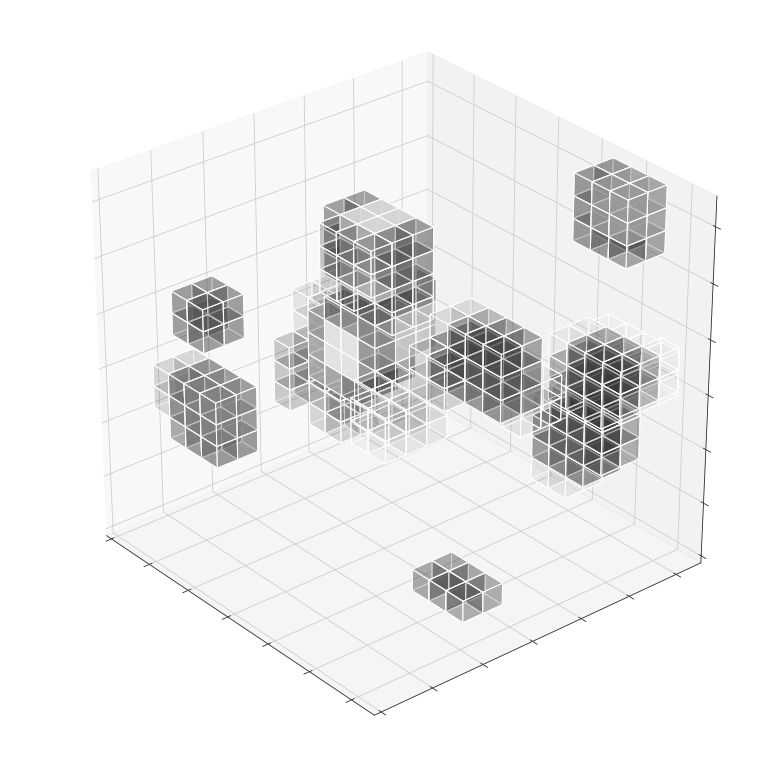

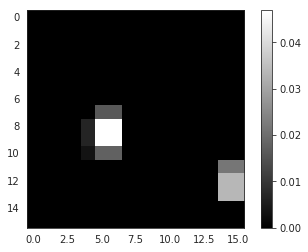

In [0]:
IMG_DIM = 16
# get feature map for first hidden layer
feature_maps = model.predict_generator(generator=training_generator, steps=None,
                                  max_queue_size=10, workers=1,
                                  use_multiprocessing=False, verbose=1)
#f_min, f_max = feature_maps.min(), feature_maps.max()
#feature_maps = (feature_maps - f_min) / (f_max - f_min)
# plot all 32 maps in an 8x4 squares
row, col = 1, 1
idx = 1
#fig = plt.figure(figsize=(35/2.54, 35/2.54))
fig = plt.figure(figsize=(35/2.54, 35/2.54))
for row_idx in range(row):
	for col_idx in range(col):
		plot_cube(feature_maps[0,:,:,:,12], row, col, idx=idx)
		idx += 1
# show the figure
plt.show()

plt.figure()
plt.imshow(feature_maps[0,:,:,-1,12],cmap='gray')
plt.colorbar()
plt.show()

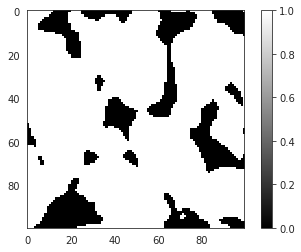

In [0]:
img = np.load('berea_01019_0.7928930_0.0873476.npy')
img = img/np.max(img)
plt.figure()
plt.imshow(img[:,:,-1], cmap='gray')
plt.colorbar()
plt.show()

In [0]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

IMG_DIM = 100
img = np.load('berea_00001_0.7708430_0.0903741.npy')
img = img/np.max(img)
ma = img

N1 = 100
N2 = 100
N3 = 100


#fig = plt.figure()
#ax = fig.gca(projection='3d')
#ax.set_aspect('equal')
#
#ax.voxels(ma, edgecolor=None)
#
#plt.show()


ma = normalize(ma)

facecolors = cm.gray(ma)
facecolors[:,:,:,-1] = ma
facecolors = explode(facecolors)

filled = facecolors[:,:,:,-1] != 0
x, y, z = expand_coordinates(np.indices(np.array(filled.shape) + 1))

fig = plt.figure(figsize=(30/2.54, 30/2.54))
ax = fig.gca(projection='3d')
ax.view_init(30, 320)
ax.set_xlim(right=IMG_DIM*2)
ax.set_ylim(top=IMG_DIM*2)
ax.set_zlim(top=IMG_DIM*2)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

ax.voxels(x, y, z, filled, facecolors=facecolors, edgecolor=None)
plt.show()

In [0]:
#Save history
history_df = pd.DataFrame.from_dict(history.history)
history_df.to_excel('../../005_Result/CNN_3D/History_CNN3D_00'+str(exp_num)+'.xlsx')

In [0]:
#Store the training & testing result
total_result = model.predict_generator(generator=total_generator, steps=None,
                                  max_queue_size=10, workers=1,
                                  use_multiprocessing=False, verbose=1)

In [0]:
testing_len = 1260
#Save result
training_result = {
		'true_training': np.reshape(k_norm[:training_len]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(training_len,)),
		'pred_training': np.reshape(total_result[:training_len]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(training_len,)), 
    'phi': 1-np.array(phi[:training_len])
		}
testing_result = {
    'true_testing': np.reshape(k_norm[training_len:total_len-1]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(testing_len,)),
		'pred_testing': np.reshape(total_result[training_len:total_len]*0.09799*(5.345*10**(-6))**2/(0.987*10**(-12))*1000,(testing_len,)),
    'phi': 1-np.array(phi[training_len:total_len-1])
        }
training_result_df = pd.DataFrame.from_dict(training_result)
testing_result_df = pd.DataFrame.from_dict(testing_result)
training_result_df.to_excel('../../005_Result/CNN_3D/Training_CNN3D_00'+
                            str(exp_num)+'_'+str(r2_score (k_norm[:training_len]*np.max(k), total_result[:training_len]*np.max(k))*100)+'.xlsx')
testing_result_df.to_excel('../../005_Result/CNN_3D/Testing_CNN3D_00'+
                            str(exp_num)+'_'+str(r2_score(k_norm[training_len:total_len-1]*np.max(k), total_result[training_len:total_len]*np.max(k))*100)+'.xlsx')


In [0]:
#Impport data
i = exp_num
Training = training_result_df
Error_training =np.abs(Training['true_training'].values-Training['pred_training'].values)/Training['true_training'].values
Training['Error'] = Error_training
Training.index.names = ['Subsample']
Testing = testing_result_df
Error_testing =np.abs(Testing['true_testing'].values-Testing['pred_testing'].values)/Testing['true_testing'].values
Testing['Error'] = Error_testing
Testing.index.names = ['Subsample']
    
#Plot training data
plt.figure()
sns.scatterplot(x=range(1,training_len+1), y='true_training', data = Training)
sns.scatterplot(x=range(1,training_len+1), y='pred_training', data = Training)
plt.ylabel('$\phi^3/ssa^2$')
plt.xlabel('Subsample')
plt.title('Permeabilitas Kozeny Carman vs CNN untuk 20 Epoch \n Data Training Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Training['true_training'], Training['pred_training'])*100))
plt.legend(['k true', 'k pred'])
plt.xticks(np.arange(1,training_len+1,testing_len))

#Plot training data
plt.figure()
#sns.scatterplot(x=phi[:training_len], y=Training.loc[:training_len, 'true_training'], size = 1)
#sns.scatterplot(x=phi[:training_len], y=Training.loc[:training_len, 'pred_training'], size = 1)
sns.scatterplot(x='phi', y='true_training', data = Training)
sns.scatterplot(x='phi', y='pred_training', data = Training)
#plt.ylabel('$\phi^3/ssa^2$')
#plt.xlabel('Subsample')
#plt.title('Permeabilitas Kozeny Carman vs CNN untuk 20 Epoch \n Data Training Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Training['true_training'], Training['pred_training'])*100))
#plt.legend(['k true', 'k pred'])
#plt.xticks(np.arange(1,training_len+1,1000))
    
#Plot error training data
plt.figure()
sns.scatterplot(x='true_training', y='Error', data = Training)
plt.ylabel('|k_true-k_pred|/k_true')
plt.xlabel('$\phi^3/ssa^2$')
plt.title('Plot Error untuk Setiap Nilai Permeabilitas \n pada 20 Epoch Data Training Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Training['true_training'], Training['pred_training'])*100))

              
#Plot testing data
plt.figure()
sns.scatterplot(x=range(1,testing_len+1), y='true_testing', data = Testing)
sns.scatterplot(x=range(1,testing_len+1), y='pred_testing', data = Testing)
plt.ylabel('$\phi^3/ssa^2$')
plt.xlabel('Subsample')
plt.title('Permeabilitas Kozeny Carman vs CNN untuk 20 Epoch \n Data Testing Arsitektur #{} ($R^2$ = {:2.2f}%)' .format(i, r2_score(Testing['true_testing'], Testing['pred_testing'])*100))
plt.legend(['k true', 'k pred'])
plt.xticks(np.arange(1,testing_len+1,1))
    
#Plot error testing data
plt.figure()
sns.scatterplot(x='true_testing', y='Error', data = Testing)
plt.ylabel('|k_true-k_pred|/k_true')
plt.xlabel('$\phi^3/ssa^2$')
plt.title('Plot Error untuk Setiap Nilai Permeabilitas \n pada 20 Epoch Data Testing Arsitektur #{}' .format(i))

print(r2_score(Training['true_training'], Training['pred_training']))
print(r2_score(Testing['true_testing'], Testing['pred_testing']))

In [0]:
#Copy result from colab to gdrive
from shutil import copyfile
#History
copyfile('../../005_Result/CNN_3D/History_CNN3D_00'+str(exp_num)+'.xlsx',
         '../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/History_CNN3D_00'+str(exp_num)+'.xlsx')
#Training
copyfile('../../005_Result/CNN_3D/Training_CNN3D_00'+
         str(exp_num)+'_'+str(r2_score (k_norm[:training_len]*np.max(k), total_result[:training_len]*np.max(k))*100)+'.xlsx',
         '../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Training_CNN3D_00'+str(exp_num)+'.xlsx')
         
#Testing
copyfile('../../005_Result/CNN_3D/Testing_CNN3D_00'+
         str(exp_num)+'_'+str(r2_score(k_norm[training_len:total_len-1]*np.max(k), total_result[training_len:total_len]*np.max(k))*100)+'.xlsx',
         '../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Testing_CNN3D_00'+str(exp_num)+'.xlsx')

'../../../gdrive/My Drive/CNN_Permeability/005_Result/CNN_3D_v2/Testing_CNN3D_00991.xlsx'